In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
import time
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv("final_data.csv")

In [3]:
df.head()

,Unnamed: 0,LOCATION,WIN_LOSE,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,PTS_TYPE,SHOT_RESULT,SHOT_DISTANCE_METERS,CLOSEST_DEF_DIST_METERS
0,0,0,1,24,1,1,651,10.8,2,1.9,2,0,2.346845,0.396221
1,1,0,1,24,2,1,706,3.4,0,0.8,3,1,8.594941,1.859189
2,2,0,1,24,3,1,720,0.0,3,2.7,2,1,3.078330,0.274307
3,3,0,1,24,4,2,733,10.3,2,1.9,2,1,5.242304,1.036269
4,4,0,1,24,5,2,806,10.9,2,2.7,2,1,1.127705,0.335264


In [4]:
df = df.drop(columns=['Unnamed: 0'])

In [5]:
df.loc[df['SHOT_RESULT'] == 1, 'SHOT_RESULT'] = -1
df.loc[df['SHOT_RESULT'] == 0, 'SHOT_RESULT'] = 1

In [6]:
df = df.reindex(columns=sorted(df.columns))
df = df.reindex(columns=(['SHOT_RESULT'] + list([a for a in df.columns if a != 'SHOT_RESULT'])))

In [7]:
df.head()

,SHOT_RESULT,CLOSEST_DEF_DIST_METERS,DRIBBLES,FINAL_MARGIN,GAME_CLOCK,LOCATION,PERIOD,PTS_TYPE,SHOT_CLOCK,SHOT_DISTANCE_METERS,SHOT_NUMBER,TOUCH_TIME,WIN_LOSE
0,1,0.396221,2,24,651,0,1,2,10.8,2.346845,1,1.9,1
1,-1,1.859189,0,24,706,0,1,3,3.4,8.594941,2,0.8,1
2,-1,0.274307,3,24,720,0,1,2,0.0,3.078330,3,2.7,1
3,-1,1.036269,2,24,733,0,2,2,10.3,5.242304,4,1.9,1
4,-1,0.335264,2,24,806,0,2,2,10.9,1.127705,5,2.7,1


In [8]:
Y = df.iloc[:,0]

In [9]:
Y.head()

0    1
1   -1
2   -1
3   -1
4   -1
Name: SHOT_RESULT, dtype: int64

In [10]:
X = df.drop(df.columns[[0]],axis=1)

In [11]:
X.head()

,CLOSEST_DEF_DIST_METERS,DRIBBLES,FINAL_MARGIN,GAME_CLOCK,LOCATION,PERIOD,PTS_TYPE,SHOT_CLOCK,SHOT_DISTANCE_METERS,SHOT_NUMBER,TOUCH_TIME,WIN_LOSE
0,0.396221,2,24,651,0,1,2,10.8,2.346845,1,1.9,1
1,1.859189,0,24,706,0,1,3,3.4,8.594941,2,0.8,1
2,0.274307,3,24,720,0,1,2,0.0,3.078330,3,2.7,1
3,1.036269,2,24,733,0,2,2,10.3,5.242304,4,1.9,1
4,0.335264,2,24,806,0,2,2,10.9,1.127705,5,2.7,1


### Correlated features
Maybe it could help to diagnose and remove correlated features because they can cause problems with convergence and can reduce the model's ability to generalize to new data. Additionally, using correlated features can inflate the importance of those features, making it difficult to interpret the model's results.

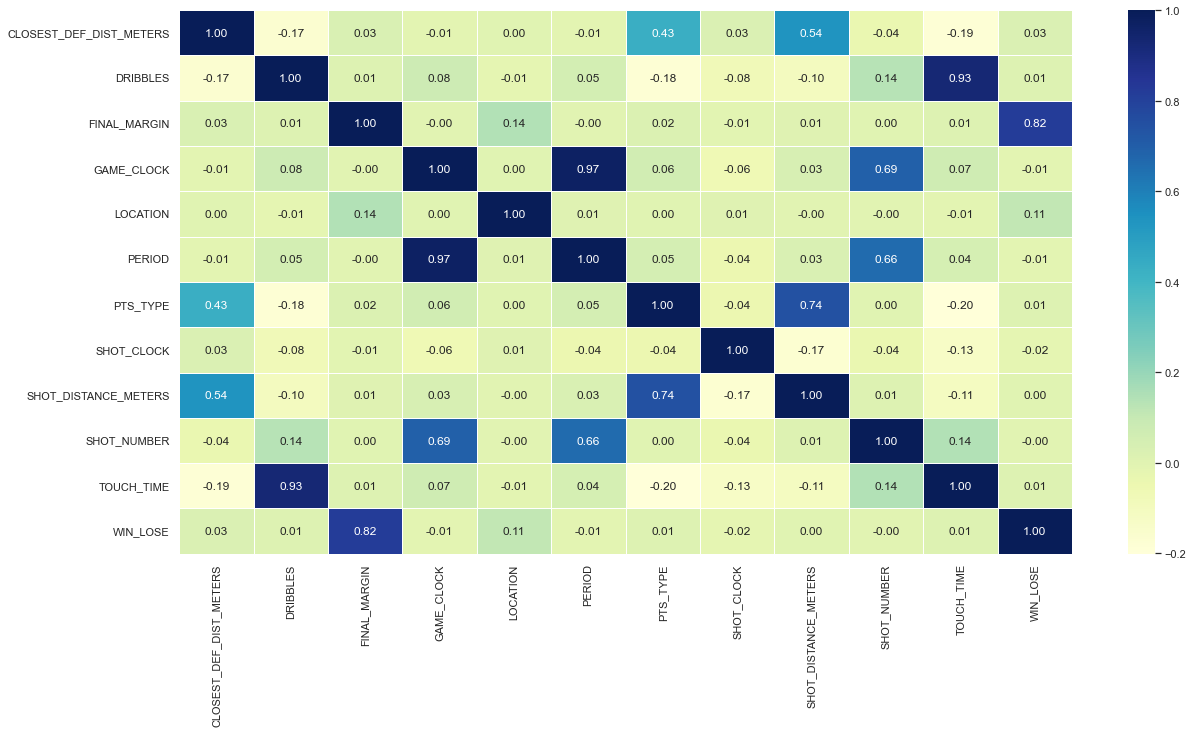

In [12]:
sns.set(rc={'figure.figsize':(20,10)})
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.show()

Highest correlation is between DRIBBLES and TOUCH_TIME and between PERIOD and GAME_CLOCK so we will remove one of them in both cases.

In [13]:
X = X.drop('TOUCH_TIME', axis=1)

In [14]:
X = X.drop('PERIOD', axis=1)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0)

### MinMaxScaler
This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

In [16]:
scaler = MinMaxScaler()
start = time.time()
clf = SVC(C=1.0, kernel='rbf').fit(scaler.fit_transform(X_train), Y_train)
y_pred = clf.predict(scaler.transform(X_test))
end = time.time()

In [17]:
print('SVC algorithm duration in seconds: ' + str(end-start))

SVC algorithm duration in seconds: 652.9328286647797


In [18]:
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
precision = precision_score(Y_test, y_pred, average='binary')
print("Precision: %.2f%%" % (precision * 100.0))
recall = recall_score(Y_test, y_pred, average='binary')
print("Recall: %.2f%%" % (precision * 100.0))

Accuracy: 62.16%
Precision: 63.83%
Recall: 63.83%


In [19]:
#n_estimators = 10
#start = time.time()
#clf = OneVsRestClassifier(SVC(kernel='linear', probability=True), n_jobs=-1)
#clf.fit(X_train, Y_train)
#end = time.time()
#print("Bagging SVC " + str(end - start) + str(clf.score(X_test, Y_test)))
#proba = clf.predict_proba(X_test)

### AUC - ROC Curve
AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

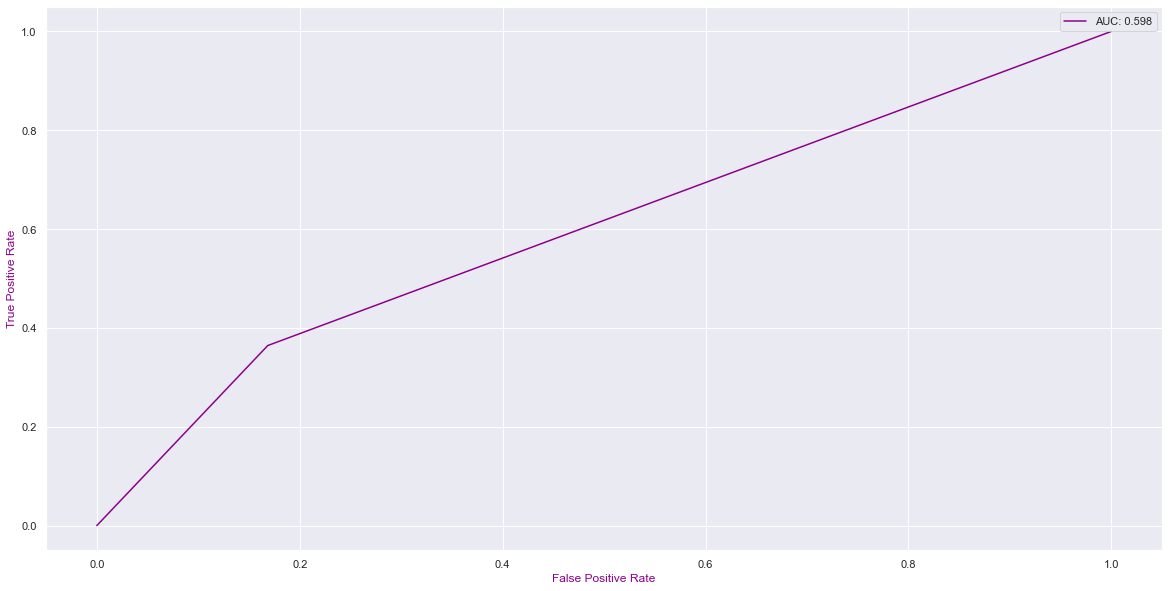

In [20]:
# calculate the AUC score
auc = roc_auc_score(Y_test, y_pred)

# calculate the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)

# plot the ROC curve
plt.plot(fpr, tpr, label="AUC: {:.3f}".format(auc), color='darkmagenta')
plt.xlabel("False Positive Rate", color='darkmagenta')
plt.ylabel("True Positive Rate", color='darkmagenta')
plt.legend(loc="best")
plt.show()

### Confusion matrix

Confusion matrix is computed to evaluate the accuracy of a classification.
By definition a confusion matrix C is such that Ci,j is equal to the number of observations known to be in group i and predicted to be in group j.
Thus in binary classification, the count of true negatives is C0,0, false negatives is C1,0, true positives is C1,1 and false positives is C0,1.

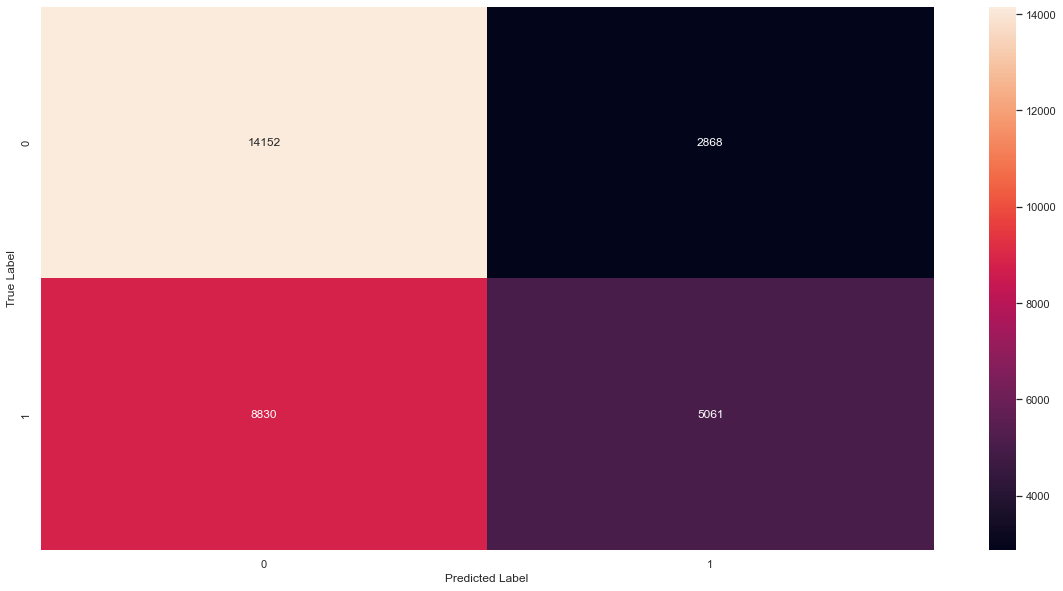

In [21]:
# calculate the confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()